In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat import load_generator_network, get_shallow_copy_function
from definitions.predictor.aparent_w_dense_functional import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

from scipy.optimize import basinhopping, OptimizeResult

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
saved_predictor_model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

saved_predictor = load_model(saved_predictor_model_path)

acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [46]:

def _store_sequence(run_dir, run_prefix, seq, curr_iter) :
    #Save sequence to file
    with open(run_dir + run_prefix + "_iter_" + str(int(curr_iter)) + ".txt", "a+") as f :
        f.write(seq + "\n")

def get_step_func(predictor, sequence_template, acgt_encoder) :
    
    available_positions = [
        j for j in range(len(sequence_template)) if sequence_template[j] == 'N'
    ]
    
    available_nt_dict = {
        0 : [1, 2, 3],
        1 : [0, 2, 3],
        2 : [1, 0, 3],
        3 : [1, 2, 0]
    }
        
    _predict_func = get_predict_func(predictor, len(sequence_template))
    
    def _step_func(x, sequence_template=sequence_template, available_positions=available_positions, available_nt_dict=available_nt_dict) :
        
        onehot = np.expand_dims(np.expand_dims(x.reshape((len(sequence_template), 4)), axis=0), axis=-1)
        
        #Choose random position and nucleotide identity
        rand_pos = np.random.choice(available_positions)
        
        curr_nt = np.argmax(onehot[0, rand_pos, :, 0])
        rand_nt = np.random.choice(available_nt_dict[curr_nt])
        
        #Swap nucleotides
        onehot[0, rand_pos, :, 0] = 0.
        onehot[0, rand_pos, rand_nt, 0] = 1.
        
        new_x = np.ravel(onehot)
        
        return new_x
    
    return _step_func

def get_predict_func(predictor, seq_len) :
    fake_lib = np.zeros((1, 13))
    fake_lib[:, 5] = 1.
    fake_d = np.ones((1, 1))
    
    def _predict_func(x, predictor=predictor, fake_lib=fake_lib, fake_d=fake_d, seq_len=seq_len) :
        
        onehot = np.expand_dims(np.expand_dims(x.reshape((seq_len, 4)), axis=0), axis=-1)
        
        iso_pred, _ = predictor.predict(x=[onehot, fake_lib, fake_d], batch_size=1)
        score_pred = np.log(iso_pred[0, 0] / (1. - iso_pred[0, 0]))

        return -score_pred
    
    return _predict_func

def run_simulated_annealing(run_prefix, predictor, sequence_template, acgt_encoder, n_iters=1000, n_iters_per_temperate=100, temperature_init=1.0, temperature_func=None, verbose=False) :
    
    run_dir = "./samples/" + run_prefix + "/"
    run_prefix = "intermediate"
    
    if not os.path.exists(run_dir): os.makedirs(run_dir)
    
    if temperature_func is None :
        temperature_func = lambda t, curr_iter, t_init=temperature_init, total_iters=n_iters: t
    
    n_epochs = n_iters // n_iters_per_temperate
    
    predict_func = get_predict_func(predictor, len(sequence_template))
    step_func = get_step_func(predictor, sequence_template, acgt_encoder)
    
    #Random initialization
    random_sequence = ''.join([
        sequence_template[j] if sequence_template[j] != 'N' else np.random.choice(['A', 'C', 'G', 'T'])
        for j in range(len(sequence_template))
    ])

    x0 = np.ravel(acgt_encoder.encode(random_sequence))
    
    x = x0
    temperature = temperature_init
    
    seq_opt = ""
    tracked_scores = [predict_func(x)]
    for epoch_ix in range(n_epochs) :
        
        x_opt, f_opt = run_basinhopping(x, predict_func, step_func, n_iters=n_iters_per_temperate, temperature=temperature)
    
        onehot_opt = np.expand_dims(np.expand_dims(x_opt.reshape((len(sequence_template), 4)), axis=0), axis=-1)

        seq_opt = acgt_encoder.decode(onehot_opt[0, :, :, 0])
        score_opt = -f_opt
        tracked_scores.append(score_opt)
        
        if verbose :
            print("Iter " + str((epoch_ix + 1) * n_iters_per_temperate) + ", Temp = " + str(round(temperature, 4)) + ", Score = " + str(round(score_opt, 4)) + "...")

        _store_sequence(run_dir, run_prefix, seq_opt, (epoch_ix + 1) * n_iters_per_temperate)
        
        x = x_opt
        temperature = temperature_func(temperature, (epoch_ix + 1) * n_iters_per_temperate)
    
    return seq_opt, np.array(tracked_scores)
        
        
def run_basinhopping(x, predict_func, step_func, n_iters=1000, temperature=1.0) :
    
    def _dummy_min_opt(fun, x0, args=(), **options) :
        return OptimizeResult(fun=fun(x0), x=x0, nit=0, nfev=0, success=True)
    
    minimizer_kwargs = {
        'method' : _dummy_min_opt,
        'options' : { 'maxiter' : 0 }
    }
    
    opt_res = basinhopping(predict_func, x, minimizer_kwargs=minimizer_kwargs, stepsize=None, niter=n_iters, T=temperature, take_step=step_func)
    
    return opt_res.x, opt_res.fun


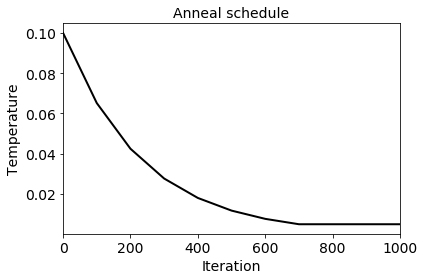

Optimized sequence 0. Score = 11.7377
Optimized sequence 100. Score = 13.3774
Optimized sequence 200. Score = 13.9965
Optimized sequence 300. Score = 11.4315
Optimized sequence 400. Score = 12.0712
Optimized sequence 500. Score = 11.5986
Optimized sequence 600. Score = 11.4426
Optimized sequence 700. Score = 12.0922
Optimized sequence 800. Score = 11.2239
Optimized sequence 900. Score = 9.4998
Optimized sequence 1000. Score = 10.9936
Optimized sequence 1100. Score = 10.0535
Optimized sequence 1200. Score = 11.5479
Optimized sequence 1300. Score = 12.6843
Optimized sequence 1400. Score = 12.0506
Optimized sequence 1500. Score = 10.0315
Optimized sequence 1600. Score = 10.861
Optimized sequence 1700. Score = 11.848
Optimized sequence 1800. Score = 11.848
Optimized sequence 1900. Score = 11.4426
Optimized sequence 2000. Score = 12.0304
Optimized sequence 2100. Score = 11.1141
Optimized sequence 2200. Score = 11.5235
Optimized sequence 2300. Score = 11.6797
Optimized sequence 2400. Score =

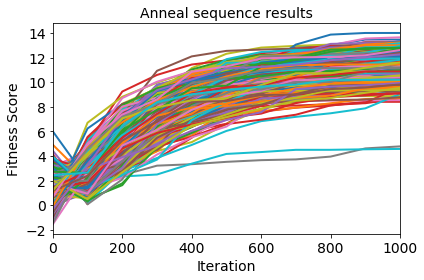

In [57]:
#Run the basinhopping algorithm

run_prefix = "basinhopping_apa_max_isoform_simple_1000_iters"

sequence_template = 'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'

n_sequences = 4096
n_iters = 1000
n_iters_per_temperate = 100

verbose = False

t_init = 0.1
t_func = lambda t, curr_iter, t_init=t_init, total_iters=n_iters, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))

f = plt.figure(figsize=(6, 4))

it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperate for epoch_ix in range(n_iters // n_iters_per_temperate)]
temp = t_init
temp_space = [temp]
for j in range(1, len(it_space)) :
    it = it_space[j]
    temp = t_func(temp, it)
    temp_space.append(temp)

plt.plot(it_space, temp_space, linewidth=2, color='black', linestyle='-')

plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.title("Anneal schedule", fontsize=14)

plt.xlim(0, np.max(it_space))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

optimized_seqs = []
optimized_trajs = []
for sequence_ix in range(n_sequences) :
    
    seq, scores = run_simulated_annealing(run_prefix, saved_predictor, sequence_template, acgt_encoder, n_iters=n_iters, n_iters_per_temperate=n_iters_per_temperate, temperature_init=t_init, temperature_func=t_func, verbose=verbose)
    
    if sequence_ix % 100 == 0 :
        print("Optimized sequence " + str(sequence_ix) + ". Score = " + str(round(scores[-1], 4)))
    
    optimized_seqs.append(seq)
    optimized_trajs.append(scores.reshape(1, -1))

optimized_trajs = np.concatenate(optimized_trajs, axis=0)

print("Finished optimizing " + str(optimized_trajs.shape[0]) + " sequences.")

plot_n_trajs = min(optimized_trajs.shape[0], 500)

f = plt.figure(figsize=(6, 4))

it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperate for epoch_ix in range(n_iters // n_iters_per_temperate)]

for i in range(plot_n_trajs) :
    plt.plot(it_space, optimized_trajs[i, :], linewidth=2, linestyle='-')

plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Fitness Score", fontsize=14)
plt.title("Anneal sequence results", fontsize=14)

plt.xlim(0, np.max(it_space))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


In [58]:

#Save sequences to file
with open(run_prefix + "_4096_sequences.txt", "wt") as f:
    for i in range(len(optimized_seqs)) :
        f.write(optimized_seqs[i] + "\n")
